### Training


In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn


In [3]:
DATA_PATH = "data.json"

VAL_SIZE = 0.2
TEST_SIZE = 0.1

In [4]:
# load training data from json file

with open(DATA_PATH, "r") as f:
    data = json.load(f)

X = np.array(data["mfcc"])
y = np.array(data["labels"])


In [5]:
# split data into train, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VAL_SIZE)

# add an axis to input sets to match the shape CNN expects (last axis is like channel in color images)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]


In [6]:
# build model

model = keras.Sequential()

# 1st conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# 2nd conv layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# 3rd conv layer
model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))

# output layer
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


2023-12-16 17:42:06.358689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 17:42:06.551734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 17:42:06.552743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 17:42:06.554318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 17:42:06.554799: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 429, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 215, 6, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 215, 6, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 107, 2, 32)        0         
 g2D)                                                            
                                                        

In [7]:
# train model

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30


2023-12-16 17:42:19.979763: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 151684416 exceeds 10% of free system memory.
2023-12-16 17:42:20.173063: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 151684416 exceeds 10% of free system memory.
2023-12-16 17:42:21.797051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2023-12-16 17:42:22.241604: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 17:42:22.906274: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa65fa30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-16 17:42:22.906326: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 970, Compute Capability 5.2
2023-12-16 17:42:22.936089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash rep

212/212 [==============================] - 8s 16ms/step - loss: 2.4807 - accuracy: 0.2234 - val_loss: 1.8179 - val_accuracy: 0.3664
Epoch 2/30
212/212 [==============================] - 3s 14ms/step - loss: 1.7992 - accuracy: 0.3917 - val_loss: 1.5414 - val_accuracy: 0.4722
Epoch 3/30
212/212 [==============================] - 3s 13ms/step - loss: 1.5304 - accuracy: 0.4721 - val_loss: 1.4123 - val_accuracy: 0.5106
Epoch 4/30
212/212 [==============================] - 3s 12ms/step - loss: 1.3347 - accuracy: 0.5457 - val_loss: 1.2420 - val_accuracy: 0.5686
Epoch 5/30
212/212 [==============================] - 3s 14ms/step - loss: 1.1850 - accuracy: 0.5863 - val_loss: 1.1374 - val_accuracy: 0.6070
Epoch 6/30
212/212 [==============================] - 4s 19ms/step - loss: 1.0961 - accuracy: 0.6186 - val_loss: 1.1122 - val_accuracy: 0.6135
Epoch 7/30
212/212 [==============================] - 3s 16ms/step - loss: 1.0009 - accuracy: 0.6540 - val_loss: 1.0005 - val_accuracy: 0.6548
Epoch 8/30

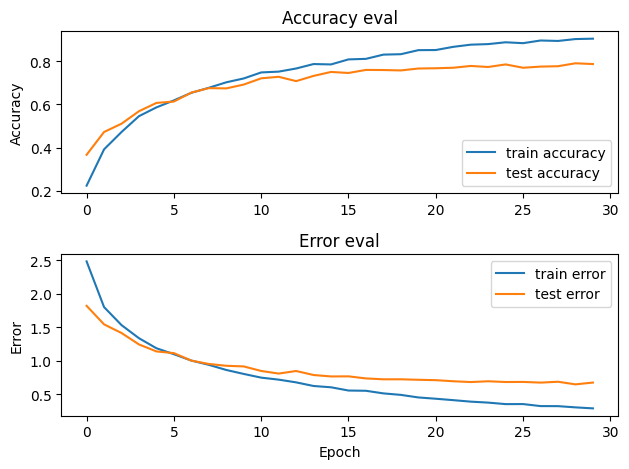

In [8]:
# plot accuracy/error for training and validation

fig, axs = plt.subplots(2)

# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error subplot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

fig.tight_layout()
plt.show()


In [9]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


30/30 - 1s - loss: 0.6112 - accuracy: 0.8191 - 582ms/epoch - 19ms/step
Test accuracy: 0.8191489577293396


30/30 [==============================] - 0s 10ms/step
tf.Tensor(
[[74  3  0  6  1  1  4  2  2  4]
 [ 4 91  1  1  0  0  0  1  0  0]
 [ 1  0 89  0  0  3  7  0  1  3]
 [ 3  0  0 89  0  1  0  0  1  0]
 [ 4  0  0  5 78  0  0  1  0  1]
 [ 1  1  2  0  2 67  3  2  1  2]
 [ 4  0  1  2  0  4 71  3  0  7]
 [ 4  0  2  0  1  0  7 66  8  6]
 [ 3  2  1  1  0  5  1  3 88  3]
 [ 4  2  2  1  0  3  6  6  3 57]], shape=(10, 10), dtype=int32)
[ 97  98 104  94  89  81  92  94 107  84]


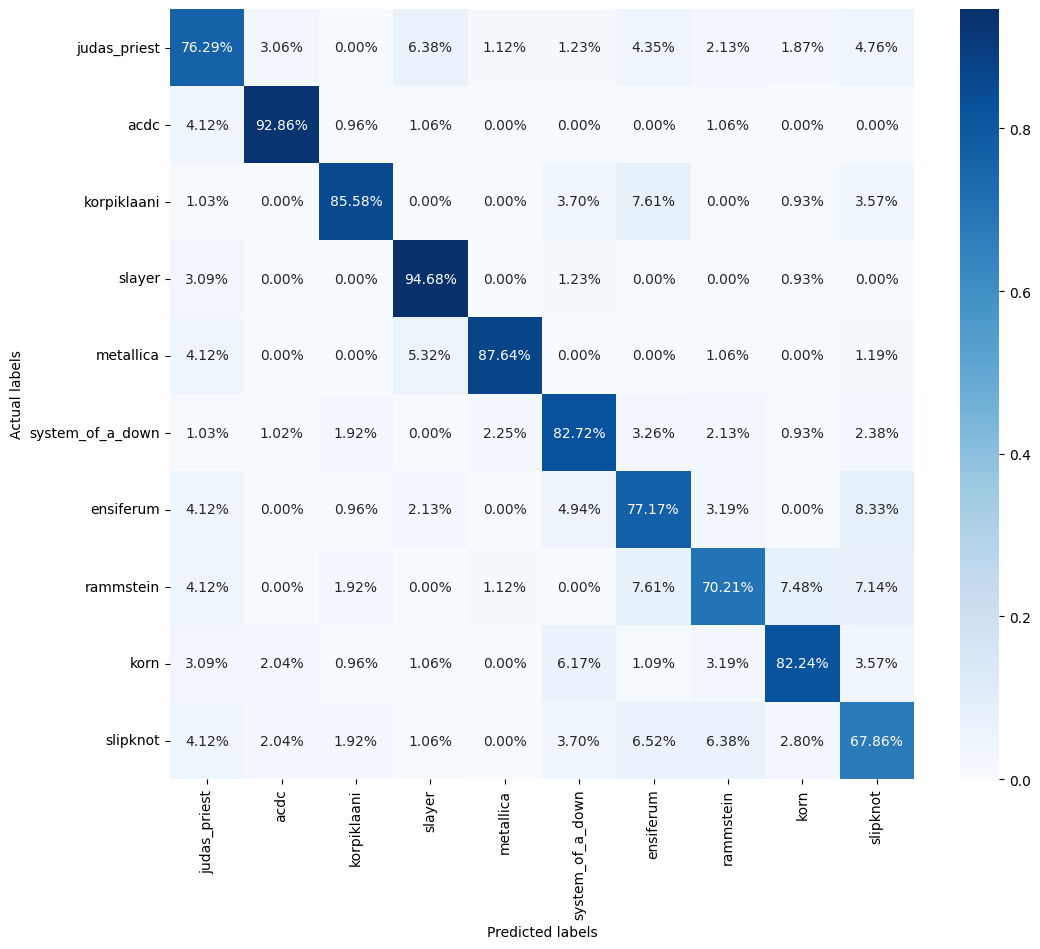

In [11]:
predictions = model.predict(X_test)
#predictions[i] = predicted_index
pred_argmax = []

for i in range(len(predictions)):
    predicted_index = np.argmax(predictions[i])
    pred_argmax.append(predicted_index)

conf_matrix = tf.math.confusion_matrix(labels=y_test, predictions=pred_argmax)
print(conf_matrix)

cat = data["mapping"]
fig, ax = plt.subplots(figsize=(12,10), facecolor='white')
#sn.heatmap(conf_matrix, annot=True, fmt='', xticklabels=cat, yticklabels=cat, cmap='Blues')
sn.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.2%', xticklabels=cat, yticklabels=cat, cmap='Blues')
ax.set(xlabel="Predicted labels", ylabel="Actual labels")

print(np.sum(conf_matrix, axis=1))

In [20]:
# pick a sample to predict from the test set
X_to_predict = X_test[150]
y_to_predict = y_test[150]

# predict sample

# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_for_prediciton = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

# perform prediction
prediction = model.predict(X_for_prediciton)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)
print(cat)
print(f"Target: {y_to_predict}, Predicted label: {predicted_index}")

1/1 [==============================] - 0s 42ms/step
['judas_priest', 'acdc', 'korpiklaani', 'slayer', 'metallica', 'system_of_a_down', 'ensiferum', 'rammstein', 'korn', 'slipknot']
Target: 6, Predicted label: [6]
